In [1]:
import os

HOME = os.getcwd()
print(HOME)

LAYOUTS = '../inputs/layout_outputs'
PRODUCTS = '../inputs/products'
LAYOUTS

c:\Users\DAAI.DESKTOP-128VDS1\Documents\deva\mfs\overlaying


'../inputs/layout_outputs'

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.spatial import distance as dist

In [49]:

from key_point_extractor_utils import get_rectangles

class MaskBlender:
    def __init__(self, layout_path, mat_path, seg_masks, src_img):
        self.layout_path = layout_path
        self.layout_img = cv2.imread(layout_path)
        self.mat_path = mat_path
        
        self.src_img = src_img
        
        self.all_masks = self.__read_imgs(seg_masks)

        self.all_rectangles1 = self.find_rectangle_manually(self.all_masks)

        self.rectangles = get_rectangles(self.layout_path, self.mat_path)
        self.all_rectangles = self.rectangles[1].copy()
        self.all_rectangles.extend(self.rectangles[0])    

        # processed_img_variables
        self.rescaled_subject = None
    
        self.selected_warp = None
        self.selected_gray_mask = None
        
        self.transformed_warp = None    
        self.final_out = self.src_img.copy()
        
    def __rect_isIn(self, point, rectangle):
        x, y = point
        vertices = np.append(rectangle, [rectangle[0]], axis=0)
    
        crossing_number = 0
        for i in range(len(vertices) - 1):
            x1, y1 = vertices[i]
            x2, y2 = vertices[i + 1]
            if ((y1 <= y < y2) or (y2 <= y < y1)) and (x < (x1 - x2) * (y - y2) / (y1 - y2) + x2):
                crossing_number += 1
        return crossing_number % 2 == 1

    def __mask_is_in(self, point, mask):
        rect = self.find_rectangle_manually([mask])[0]
        return self.__rect_isIn(point, rect)

    def findRectangle_from_cursor(self, rectangles, cursorPosition):
        for rect in rectangles:
            if self.__rect_isIn(cursorPosition, rect):
                return rect
        return -1

    def findMask_from_cursor(self, all_masks, cursorPosition):
        for mask in all_masks:
            if self.__mask_is_in(cursorPosition, mask):
                return mask
        return -1

    def __give_user_options(self):
        n_walls = len(self.all_masks) - 1
        n_floors = 1
        options = {}
        opt_list = {}

        opt_list[0] = "Floor"
        options[0] = self.all_masks[0]
        for i in range(n_walls):
            opt_list[i+1] = "Wall"+str(i+1)
            options[i+1] = self.all_masks[1+i]
        print(opt_list)
        return options
        
    def __get_mask_imgs(self, img_path):
        mask_imgs = []
        for img in os.listdir(img_path):
            if img.split('.')[-1] == 'png':
                mask_imgs.append(img_path+"/"+img)
        return mask_imgs

    def __read_imgs(self, mask_path):
        mask_imgs = self.__get_mask_imgs(mask_path) 
        # print(mask_imgs)
        masks = []
        for img in mask_imgs:
            mask = cv2.imread(img, 0)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            ret, bw_img = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
            # print(bw_img.shape)
            # plt.imshow(mask)    
            masks.append(bw_img)    
        return masks

    def find_rectangle_manually(self, given_masks):
        rectangles = []
        for mask in given_masks:
            mask = np.array(mask)
            gray_mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
            # print(*gray_mask[400])
            row_ind = []
            for i in range(gray_mask.shape[0]):
                inds = np.where(gray_mask[i] == 255)[0]
                if inds.size != 0:
                    row_ind.append(i)
            top, bottom = row_ind[0], row_ind[-1]
            
            col_ind = []
            for i in range(gray_mask.shape[1]):
                inds = np.where(gray_mask[:, i] == 255)[0]
                if inds.size != 0:
                    col_ind.append(i)
            left, right = col_ind[0], col_ind[-1]

            rectangles.append([
                [left, top],
                [right, top],
                [right, bottom],
                [left, bottom]
            ])
        return rectangles
            
    def __find_intersection(self, point_set1, point_set2):
        # print(point_set1, point_set2)
        if point_set1[0][0] == point_set1[1][0] or point_set2[0][0] == point_set2[1][0]:
            pass
        else:
            point_set1[1], point_set2[0] = point_set2[0], point_set1[1]
        
        xdiff = (point_set1[0][0] - point_set1[1][0], point_set2[0][0] - point_set2[1][0])
        ydiff = (point_set1[0][1] - point_set1[1][1], point_set2[0][1] - point_set2[1][1])

        def det(a, b):
            return a[0] * b[1] - a[1] * b[0]

        div = det(xdiff, ydiff)
        if div == 0:
            raise Exception('lines do not intersect')

        d = (det(*point_set1), det(*point_set2))
        x = det(d, xdiff) / div
        y = det(d, ydiff) / div
        return [x, y]

    def __get_index(self, points, pt):
        for i in range(len(points)):
            p1, p2 = points[i]
            if [p1, p2] == pt:
                return i
            
    def __get_adjacent(self, points, pt):
        lpts = len(points)
        indx = self.__get_index(points, pt)
        adj1 = [i for i in points[(indx-1)%lpts]]
        adj2 = [i for i in points[(indx+1)%lpts]]
        return adj1, adj2, indx
            
    def __get_extrapt_index(self, points, pt):
        for j in range(len(points)):
            p1, p2 = points[j]
            if p2 == pt[1]:
                return j
    
    def __remove_extra_pts(self, points, extra_pts):
        new_poly = points.copy()
        for i in extra_pts:
            indx = self.__get_index(points, i)
            new_poly = np.delete(new_poly, indx, axis=0)
        return new_poly

    def __order_points(self, pts):
        # sort the points based on their x-coordinates
        xSorted = pts[np.argsort(pts[:, 0]), :]
        # grab the left-most and right-most points from the sorted
        # x-roodinate points
        leftMost = xSorted[:2, :]
        rightMost = xSorted[2:, :]
        # now, sort the left-most coordinates according to their
        # y-coordinates so we can grab the top-left and bottom-left
        # points, respectively
        leftMost = leftMost[np.argsort(leftMost[:, 1]), :]
        (tl, bl) = leftMost
        # now that we have the top-left coordinate, use it as an
        # anchor to calculate the Euclidean distance between the
        # top-left and right-most points; by the Pythagorean
        # theorem, the point with the largest distance will be
        # our bottom-right point
        D = dist.cdist(tl[np.newaxis], rightMost, "euclidean")[0]
        (br, tr) = rightMost[np.argsort(D)[::-1], :]
        # return the coordinates in top-left, top-right,
        # bottom-right, and bottom-left order
        return np.array([tl, tr, br, bl], dtype="int")

    def __reduce_points(self, polygon):
        points = polygon.copy()
        h_layout, w_layout = self.layout_img.shape[:2]
        pts1 = [[0, 0], [w_layout, 0], [w_layout, h_layout], [0, h_layout]]
        corner_pts, extra_pts = [], []
        for pt in points:
            if pt in pts1:
                corner_pts.append(pt)
            elif pt[1] == h_layout or pt[1] == 0:
                extra_pts.append(pt)
        
        pts_without_extra = self.__remove_extra_pts(polygon, extra_pts)
        # print(pts_without_extra)

        for i in range(len(corner_pts)):
            lpts = len(pts_without_extra)
            adj1, adj2, c_indx = self.__get_adjacent(pts_without_extra, corner_pts[i])
            # print(adj1, adj2)
            e_indx = self.__get_extrapt_index(extra_pts, pts_without_extra[c_indx])
            new_pt = self.__find_intersection([adj1, corner_pts[i]], [extra_pts[e_indx], adj2])
            new_pt = np.array([new_pt], dtype=int)
            
            new_rectangle = np.delete(pts_without_extra, c_indx, axis=0)
            new_rectangle = np.append(new_rectangle, new_pt, axis=0)
            new_rectangle = self.__order_points(new_rectangle)
            # print(new_rectangle)
            return new_rectangle
        
    def rescale_subject_img(self, subject_path, scale_percent):
        temp = cv2.imread(subject_path)
        subject_img = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        
        w_rescale, h_rescale = (subject_img.shape[1]*scale_percent)//100, (subject_img.shape[0]*scale_percent)//100
        h, w = subject_img.shape[:-1]
        self.rescaled_subject = cv2.resize(subject_img, [w_rescale, h_rescale], interpolation=cv2.INTER_AREA)
        
    def __calculate_w_h(self, polygon):
        n_pts = len(polygon)
        edge_2 = polygon[1:-1]
        edge_3 = polygon[2:]
        all_distances = {}
        
        for edge in [edge_2, edge_3]:
            p1 = edge[0]
            p2 = edge[1]
            # print(p1, p2)
            dist = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
            all_distances[dist] = [p1, p2]
            # print(all_distances)
        return [*all_distances.keys()]
    
    def __replicate_subject(self, polygon):
        h_subject, w_subject = self.rescaled_subject.shape[:2]

        h_base, _ = self.layout_img.shape[:2]
        _, w_base = self.__calculate_w_h(polygon)
        
        num_of_tiles_per_row = round(h_base / h_subject)-1
        num_of_tiles_per_col = round(w_base / w_subject)
        # print(num_of_tiles_per_row, num_of_tiles_per_col)

        dup_cols = self.rescaled_subject.copy()
        ## duplicate the subject image
        for i in range(num_of_tiles_per_col):
            dup_cols = np.concatenate([dup_cols, self.rescaled_subject], axis = 1)
        dup_rows = dup_cols.copy()
        for i in range(num_of_tiles_per_row):
            dup_rows = np.concatenate([dup_rows, dup_cols], axis=0)
        
        duplicated_tiles = dup_rows.copy()
        # plt.imshow(duplicated_tiles)
        return duplicated_tiles
    
    def __combine_masks(self, mode):
        combine_masks = np.zeros(self.layout_img.shape, dtype=np.uint8)
        for mask in self.all_masks[mode]:
            combine_masks = cv2.bitwise_or(combine_masks, mask)
        self.selected_gray_mask = cv2.cvtColor(combine_masks, cv2.COLOR_RGB2GRAY)
    
    def perspective_warp(self, polygon):
        if len(polygon) > 4:
            sorted_pts = self.__reduce_points(polygon)
        else:
            sorted_pts = polygon

        duplicated_sub = self.__replicate_subject(sorted_pts)
        # plt.imshow(duplicated_sub)
        h_base, w_base, c_base = self.layout_img.shape
        h_subject, w_subject = duplicated_sub.shape[:2]
        pts1 = np.float32([[0, 0], [w_subject, 0], [w_subject, h_subject], [0, h_subject]])
        pts2 = np.float32(sorted_pts)
        # print(pts1, pts2)

        transformation_matrix = cv2.getPerspectiveTransform(pts1, pts2)
        # print(transformation_matrix)
        warped_img = cv2.warpPerspective(duplicated_sub, transformation_matrix, (w_base, h_base))
        # plt.imshow(warped_img)
        return warped_img
    
    def __combine_warps(self, mode):        
        combined_warp = np.zeros(self.layout_img.shape, dtype=np.uint8)
        for polygon in self.rectangles[mode]:
            warp = self.__perspective_warp(polygon)
            combined_warp = cv2.bitwise_or(combined_warp, warp)
        self.selected_warp = combined_warp
        return combined_warp
        
    def implant_overlay(self, subject_path, rescale_percent, mouse_coords):
        self.rescale_subject_img(subject_path, rescale_percent)
        
        selected_mask = self.findMask_from_cursor(self.all_masks, mouse_coords)
        self.selected_gray_mask = cv2.cvtColor(selected_mask, cv2.COLOR_RGB2GRAY)
        overlay_coordinates = np.where(self.selected_gray_mask > 0)

        selected_rect = self.findRectangle_from_cursor(self.all_rectangles, mouse_coords)
        self.selected_warp = self.perspective_warp(selected_rect)
        
        # self.transformed_warp = cv2.bitwise_and(self.selected_warp, self.selected_gray_mask)
    
        final_img = self.final_out
        final_img[overlay_coordinates] = self.selected_warp[overlay_coordinates]
        self.final_out = final_img

        # plt.imshow(self.transformed_warp)
        return self.final_out

not_working - 3, img2
not_proper - img8, img9, test3, test4
working = img1, img3, img6, kitchen, test, test1

In [50]:
USER_IMG = 'img1'

layout_input = "../inputs/layout_outputs/{}.jpeg".format(USER_IMG)
layout_mat = "../inputs/layout_outputs/{}.txt".format(USER_IMG)
all_masks = "../inputs/masks/{}".format(USER_IMG)

src_img = cv2.imread("../inputs/src_imgs/{}.jpeg".format(USER_IMG))

st = time.time()
blender = MaskBlender(
        layout_input,
        layout_mat,
        all_masks,
        src_img,
        )
et = time.time()
"{:.3f}s".format(et-st)

'0.492s'

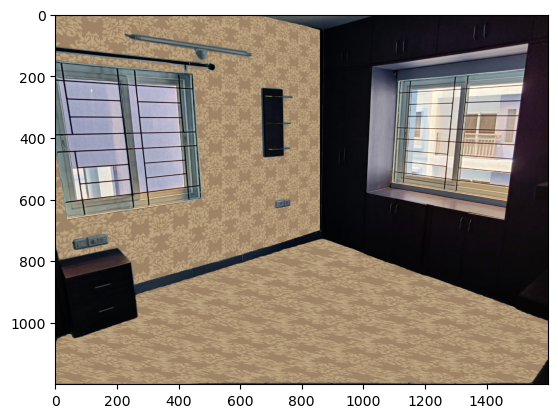

In [52]:
subject_rescale_percent = 30
sample_paint = PRODUCTS+'/Paints/Orange.jpg'
sample_stone = PRODUCTS+'/Stone/ArmaniBrown.jpg'
sample_wallpaper = PRODUCTS+'/Wallpapers/64_damask wallpaper texture-seamless.jpg'

final_out = blender.implant_overlay(sample_wallpaper, 
                                    subject_rescale_percent, 
                                    mouse_coords = [600, 400]
                                    )
plt.imshow(final_out)
# cv2.imwrite("../outs/{}.jpg".format(USER_IMG), 
#             cv2.cvtColor(blender.final_out, cv2.COLOR_BGR2RGB))